# Intro to OpenCV on Jupyter Notebooks (Filter2D + Dilate)

This notebook illustrates the kinds of things you can interactively do with OpenCV libraries in Jupyter notebooks and sets the foundation for exploring OpenCV acceleration on FPGAs through the use of overlays. This first example consists of a 2D filter and a dilate function. A 2D filter is the foundation of many vision processing functions. This notebook is organized as follows:
1. Set up USB camera
2. Run software only filter2D 
3. Run software only dilate
4. Run filter2D + dilate and measure performance
5. Plot performance
6. Stream frames from USB camera in real time
7. Setup widgets
8. Run filter2D + dilate on input frames from USB camera in real-time

## Setup and configure USB camera 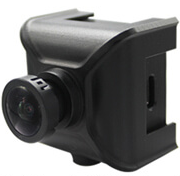
We use OpenCV (cv2) for capturing frames from a USB camera and processing those image frames. Here, we start by setting up the interface to the USB camera and configuring its resolution (1080p). A successful camera setup returns a 'True'. If something is is outputted, shutdown the notebook and restart it again.

In [ ]:
import cv2

camera = cv2.VideoCapture(0)

width = 1920
height = 1080
camera.set(cv2.CAP_PROP_FRAME_WIDTH,width)
camera.set(cv2.CAP_PROP_FRAME_HEIGHT,height)

We add another helper function which sets up an IPython-based imshow call which encodes OpenCV image data to jpeg format before displaying it within the notebook itself. Other methods of displaying image data would perform similar conversions as well.

In [ ]:
import IPython

def imshow(img):
    returnValue, buffer = cv2.imencode('.jpg', img)
    IPython.display.display(IPython.display.Image(data=buffer.tobytes()))

## Read input frame from USB camera

Read input frame and convert image to gray scale with OpenCV function cvtColor.

**NOTE**: We do a few extra reads up front to flush out the frame buffers in case camera was previously used

In [ ]:
# Flush webcam buffers (needed when rerunning notebook)
for _ in range(5):
    ret, frame_in = camera.read()

# Read in a frame
ret, frame_in = camera.read()
if ret:
    frame_in_gray = cv2.cvtColor(frame_in,cv2.COLOR_RGB2GRAY)
else:
    print("Error reading frame from camera.")    

Show input frame in notebook.

In [ ]:
imshow(frame_in_gray)

## Run SW Filter2D 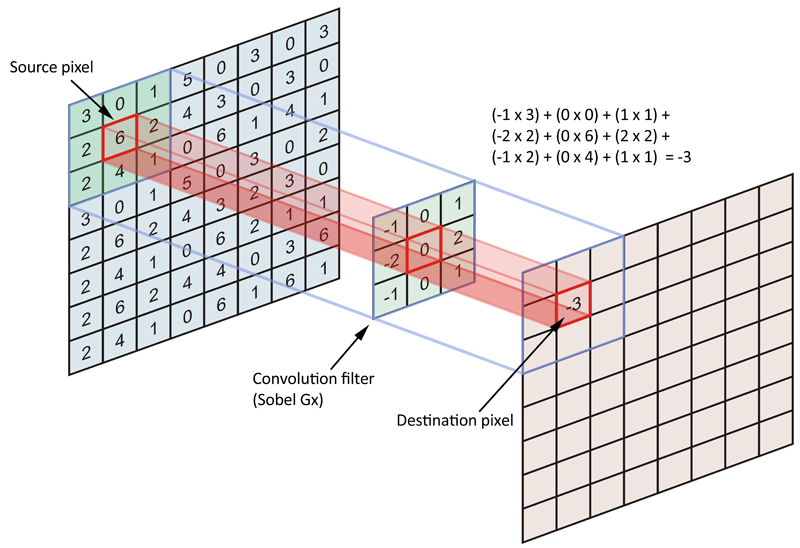
Here, we call the OpenCV 2D filter function on the input frame using kernel coefficients for a Laplacian high-pass filter (which gives a kind of edge detection). Note that many of the vision processing functions used will operate on gray scale only images. The matrix returned by filter2D is an 2D array (1920x1080) of 8-bit values denoting the brightness of each pixel.
* [OpenCV Filter2D](https://docs.opencv.org/3.2.0/d4/d86/group__imgproc__filter.html#ga27c049795ce870216ddfb366086b5a04)

In [ ]:
import numpy as np

#Sobel Hor filter  
kernelF    = np.array([[1.0,2.0,1.0],[0.0,0.0,0.0],[-1.0,-2.0,-1.0]],np.float32)
frameF = np.ones((height,width),np.uint8)

cv2.filter2D(frame_in_gray, -1, kernelF, frameF, borderType=cv2.BORDER_CONSTANT) # software 2D filter
imshow(frameF)

## Run SW Dilate
Next we do the same thing but use a dilate function which expands the size of each pixel. With the OpenCV python library, we have access to a enromous wealth of vision processing functions. Using them is not more than adding the function name after the OpenCV class (cv2). Instead of cv::Mat, we use numpy arrays to store data. Finally, if any function parameters seem unclear, try creating a cell that prints that function such as 'print(cv2.dilate)' and all function arguments and return values will be listed.
* [Dilate OpenCV link](https://docs.opencv.org/3.2.0/d4/d86/group__imgproc__filter.html#ga4ff0f3318642c4f469d0e11f242f3b6c)

In [ ]:
import numpy as np

kernelD = np.ones((3,3),np.uint8)
frameD = np.ones((height,width),np.uint8)

cv2.dilate(frameF, kernelD, frameD, iterations=1)
imshow(frameD)

## Run SW Filter2D + SW Dilate and measure performance
Once we become familiar with using OpenCV functions, we can begin combining OpenCV functions within one algorithm. By declaring a 2D filter followed by a dilate function, we effectively brighten all the lines  of our image. In addition, we will call our small image processing pipeline (filter2d, dilate) a few frames and measure the performance of each function as well as the overall performance. In order to understand the performance of our code, we enable profile using the %%prun command and write the result using the -T option to output file prunSW.

In [ ]:
%%prun -s cumulative -q -l 10 -T prunSW
import numpy as np
import time

kernelF  = np.array([[1.0,2.0,1.0],[0.0,0.0,0.0],[-1.0,-2.0,-1.0]],np.float32) #Sobel Hor filter
kernelD  = np.ones((3,3),np.uint8) 
frameF   = np.ones((height,width),np.uint8)
frameD   = np.ones((height,width),np.uint8)

num_frames    = 20

start = time.time()
for _ in range(num_frames):
    cv2.filter2D(frame_in_gray, -1, kernelF, frameF)
    cv2.dilate(frameF, kernelD, frameD, iterations=1)
time_total = time.time() - start
print("Frames per second:  " + str(num_frames / time_total))
imshow(frameD)

## Process profile results
The profile results summary list the processing tasks sorted by highest cumulative processing time (cumulative). It can likewise be sorted by total time (tottime), per call (percall).  The first two items on the list are generally the wrappers for the cell. After that, we see that our OpenCV filter2D and dilate functions take up the most of the processing time. We can parse this text file to obtain the actual per call processing time to be used later to visualize the performance. This parsing is done with the ! character which allows us to use shell commands to cat/ grep/ awk the text file and obtain the percall time (stored as a list) and then converted to type float.

In [ ]:
print(open('prunSW','r').read())
res = !cat prunSW | grep filter2D | awk '{{print $$2}}'
tottime_sw_filter2d = float(res[0])
res = !cat prunSW | grep dilate   | awk '{{print $$2}}'
tottime_sw_dilate   = float(res[0])

## Plot performance
In addition to having easy access to OpenCV functions, we can access functions from pyPlot for plotting results in graphs and charts. Here, we take the recorded time data and plot out the processing times in a bar chart along with computed FPS of each function.

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

TIME   = [t*1000/num_frames for (t) in (time_total, tottime_sw_dilate, tottime_sw_filter2d)]
FPS    = [1000/t for (t) in (TIME)]
LABELS = ['Total','Dilate','Filter2D']

f, ((ax1, ax2)) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,2))
x_pos = np.arange(len(LABELS))
plt.yticks(x_pos, LABELS)

ax1.barh(x_pos, TIME, height=0.6, color='g', zorder=3)
ax1.invert_yaxis()
ax1.set_xlabel("Execution Time per frame [ms]")
ax1.set_ylabel("Kernel")
ax1.grid(zorder=0)

ax2.barh(x_pos, FPS, height=0.6, color='b', zorder=3)
ax2.invert_yaxis()
ax2.set_xlabel("Frames per second")
ax2.grid(zorder=0)

plt.show()

## Stream frames from USB camera in real-time
The interactivity of Jupyter notebooks is great for obtaining direct feedback from python programs. We can use IPython display functions in a loop and output the USB camera frames to our noteobook in real time, thereby providing a stream of frames. To accelerate this process, image frames are converted to jpeg before streaming over the network connection to improve performance. While the speed of this interaction is not at ideal frame rates, it does provide some real-time feedback of our code, allowing us to quickly test vision function parameters on live data.

In [ ]:
num_frames = 40

start = time.time()
for _ in range(num_frames):
    # Capture frame-by-frame
    ret, frame_in = camera.read()
    if (not ret):
        # Release the Video Device if ret is false
        camera.release()
        # Message to be displayed after releasing the device
        print("Release camera resource")
        break
    imshow(frame_in)
    IPython.display.clear_output(wait=True)        
end = time.time()
print("Frames per second:  " + str(num_frames / (end - start)))  

## Setup control widgets

Here, we define some kernel configurations that will be used to change the functionality of the 2D filter on the fly. A pulldown menu will appear below this cell to be used to change the filter2D kernel used subsequent cells.

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, FloatSlider
import ipywidgets as widgets

kernel_g = np.array([[1.0,2.0,1.0],[0.0,0.0,0.0],[-1.0,-2.0,-1.0]],np.float32) #Sobel Hor  

def setKernelAndFilter3x3(kernelName):
    global kernel_g

    kernel_g = {
        'Sobel Hor': np.array([[1.0,2.0,1.0],[0.0,0.0,0.0],[-1.0,-2.0,-1.0]],np.float32),
        'Sobel Ver': np.array([[1.0,0.0,-1.0],[2.0,0.0,-2.0],[1.0,0.0,-1.0]],np.float32),
        'laplacian high-pass':  np.array([[0.0, 1.0, 0],[1.0, -4, 1.0],[0, 1.0, 0.0]],np.float32),
        'gaussian high-pass': np.array([[-0.0625,-0.125,-0.0625],[-0.125,0.75,-0.125],[-0.0625,-0.125,-0.0625]],np.float32),
        'gaussian blur': np.array([[0.0625,0.125,0.0625],[0.125,0.25,0.125],[0.0625,0.125,0.0625]],np.float32)
    }.get(kernelName, np.ones((3,3),np.float32)/9.0)

interact(setKernelAndFilter3x3, kernelName=['Sobel Hor','Sobel Ver','laplacian high-pass','gaussian high-pass','gaussian blur']);

## Run filter2D + dilate on input frames from USB camera in real-time
Now we will run the 2D filter + dilate on input frames from the USB camera and display the results in real time. We will also respond to feedback from our pulldown menu which changes the 2D filter coefficients. 

<font color=red size=4>IMPORTANT NOTE</font>: To allow for live interaction of the pull-down menu selection with the processing loop, the loop will be run as a separate thread for ~20 seconds (based on num_frames and code fps). As soon as the kernel coefficient is changed by selecting the drop-down menu, the image will instead appear under the widget cell along with the eventual reported FPS calculations. The cell will appear idle right away (\* will disappear immediately) and therefore cannot be used to indicate when the cell is done. Instead, you will look for when the FPS calculation is reported. It is **important** to make sure cell is done before moving on. You can adjust the loop run time by adjusting the num_frames variable.

In [ ]:
def loop_hw2_app():
    global kernel_g

    kernelD   = np.ones((3,3),np.uint8)
    frameF    = np.ones((height,width),np.uint8)
    frameD   = np.ones((height,width),np.uint8)

    num_frames = 60

    start = time.time()
    for _ in range(num_frames):
        # Capture frame-by-frame
        ret, frame_in = camera.read()
        if (not ret):
            # Release the Video Device if ret is false
            camera.release()
            # Message to be displayed after releasing the device
            print("Released Video Resource")
            break
        frame_in_gray = cv2.cvtColor(frame_in,cv2.COLOR_RGB2GRAY)
        cv2.filter2D(frame_in_gray, -1, kernel_g, frameF)
        cv2.dilate(frameF, kernelD, frameD, iterations=1)
        imshow(frameD)
        IPython.display.clear_output(wait=True)    

    end = time.time()
    print("Frames per second:  " + str(num_frames / (end - start)))  
from threading import Thread

t = Thread(target=loop_hw2_app, )
t.start()

## Release up USB camera

NOTE: This is needed to close the camera between subsequent runs. If the camera is unable to read a frame, be sure to call camera.release() and then try opening the VideoCapture again.

In [ ]:
camera.release()

<font color=red size=4>IMPORTANT NOTE</font>: Be sure to run the cell below, shutting down the notebook, before starting a new one. The notebook interface shows "No Kernel", the cell below will incorrectly show a running status [ * ]. You can ignore this an safely close the tab of the notebook.

In [ ]:
%%javascript
Jupyter.notebook.session.delete();